<a href="https://colab.research.google.com/github/tathi-martins/Alura-Bootcamp-Ciencia-de-Dados-Aplicada-2/blob/main/Super_Projeto_modulo03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Início - Conhecendo os dados e Objetivo:**

# **Objetivo:**

 Objetivo principal é fazer uma projeção de casos de COVID-19 para os próximos 43 dias na cidade de Araraquara. Com isso, esperamos ajudar o poder público e sua gestão na tomada de decisões no combate à COVID-19.

 **As etapas do processo:**

- 1.0 - Conhecendo o conjunto de dados;
- 2.0 - Fazendo uma breve análise exploratória;
- 3.0 - Treinando e testando os modelos;
- 4.0 - Conclusão.

# **1.0 - Conhecendo o conjunto de dados**

Vamos usar o banco de dados do estado de São Paulo com informações atualizadas sobre a COVID-19, no site do [SEADE](https://www.seade.gov.br/coronavirus/) e do [SIMI](https://www.saopaulo.sp.gov.br/planosp/simi/dados-abertos/) de São Paulo.

Os dados são atualizados diáriamente e estou usando dados que vão do início dos casos em São Paulo em março de 2020 até maio de 2021.

**Dicionário de Dados**

- nome_munic: Nome do município

- codigo_ibge: Código do município no IBGE (7 dígitos)

- datahora: Data no formato YYYY-MM-DD

- casos: Casos totais registrados até a data

- casos_novos: Casos novos registrados na data

- casos_pc: Casos totais por 100 mil habitantes

- casos_mm7d: Média móvel dos últimos 7 dias dos novos casos

- obitos: Óbitos totais registrados até a data

- obitos_novos: Óbitos novos registrados na data

- obitos_pc: Óbitos totais por 100 mil habitantes

- obitos_mm7d: Média móvel dos últimos 7 dias dos novos óbitos

- letalidade: casos / obitos

[Fonte](https://www.saopaulo.sp.gov.br/wp-content/uploads/2020/08/Dic.-dados_dados_covid_municipios_sp.pdf): Secretaria de Estado da Saúde (e-SUS, SIVEP-Gripe, RedCap).

Nota: Para visualizar o dicionário completo clique no link acima.

**Quais serão as colunas utilizadas para as previsões?** datahora e casos_novos.

# **Importando as Bibliotecas e o dataframe**

In [288]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from fbprophet import Prophet # fbprophet é só para o Google Colab, se usar outra IDE, é só tirar o fbprophet e importar como Prophet apenas.
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_tweedie_deviance
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [289]:
url = 'https://github.com/tathi-martins/Alura-Bootcamp-Ciencia-de-Dados-Aplicada-2/raw/main/Modulo03/dados_covid_sp.zip'

In [290]:
dados = pd.read_csv(url, sep=';')

In [291]:
dados.head()

,nome_munic,codigo_ibge,dia,mes,datahora,casos,casos_novos,casos_pc,casos_mm7d,obitos,obitos_novos,obitos_pc,obitos_mm7d,letalidade,nome_ra,cod_ra,nome_drs,cod_drs,pop,pop_60,area,map_leg,map_leg_s,latitude,longitude,semana_epidem
0,Adamantina,3500105,25,2,2020-02-25,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de Presidente Prudente,9,Marília,5,33894,7398,41199,0,8.0,"-21,6820","-51,0737",9
1,Adolfo,3500204,25,2,2020-02-25,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de São José do Rio Preto,14,São José do Rio Preto,15,3447,761,21106,0,8.0,"-21,2325","-49,6451",9
2,Aguaí,3500303,25,2,2020-02-25,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de Campinas,4,São João da Boa Vista,14,35608,5245,47455,0,8.0,"-22,0572","-46,9735",9
3,Águas da Prata,3500402,25,2,2020-02-25,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de Campinas,4,São João da Boa Vista,14,7797,1729,14267,0,8.0,"-21,9319","-46,7176",9
4,Águas de Lindóia,3500501,25,2,2020-02-25,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de Campinas,4,Campinas,3,18374,3275,6013,0,8.0,"-22,4733","-46,6314",9


**Preparando os dados**

In [292]:
dados['datahora'] = pd.to_datetime(dados['datahora'], format='%Y-%m-%d')

In [293]:
dados['datahora']

0        2020-02-25
1        2020-02-25
2        2020-02-25
3        2020-02-25
4        2020-02-25
            ...    
286173   2021-05-08
286174   2021-05-09
286175   2021-05-10
286176   2021-05-11
286177   2021-05-12
Name: datahora, Length: 286178, dtype: datetime64[ns]

In [331]:
# Criando o dataframe de Araraquara:
dados_araraquara = dados[(dados['nome_munic']=='Araraquara')].copy()

# **2.0 - Fazendo uma breve análise exploratória**

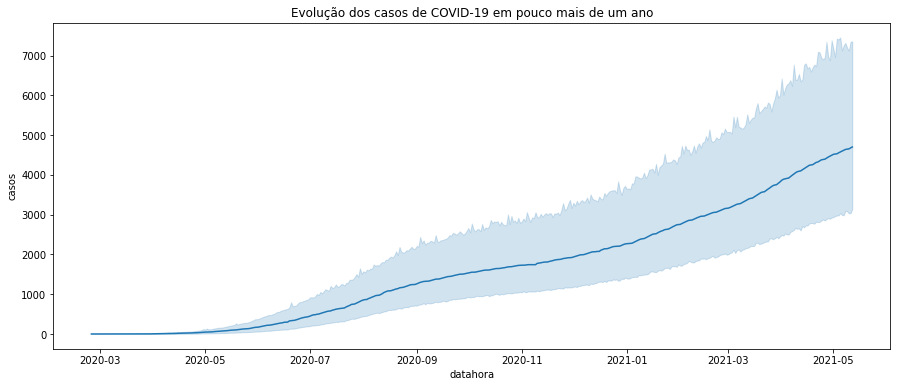

In [295]:
# Criando o gráfico de dados
plt.figure(figsize=(15,6))
sns.lineplot(data=dados, x='datahora', y='casos').set_title('Evolução dos casos de COVID-19 em pouco mais de um ano')
plt.show()

O gráfico mostra o que parece ser um crescimento exponencial de casos de COVID-19 no estado de São Paulo.

Criando um gráfico para analisarmos o crescimento logaritmo dos casos na cidade de Araraquara

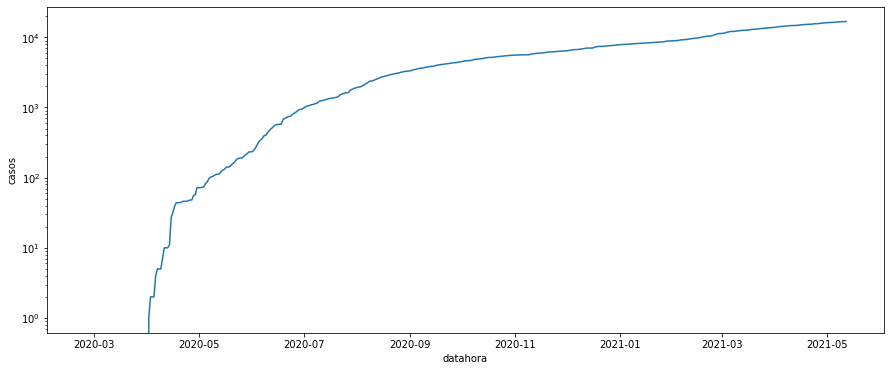

In [296]:
plt.figure(figsize=(15,6))
sns.lineplot(data=dados_araraquara, x='datahora', y='casos')
mpl.pyplot.yscale('log')

Podemos confirmar que há um crescimento exponencial de casos na cidade de Araraquara, apesar de observarmos pequenas variações, provavelmente devidas às restrições de convívio social, com fechamento do comercio entre outras atividades econômicas e do distanciamento social mais rigoroso que varia muito a cada mês.

**Vamos calcular a média móvel de casos e de óbitos:**

In [332]:
dados_araraquara['media_movel_casos'] = dados_araraquara['casos_novos'].rolling(window=7, center=False).mean() # Média móvel dos últimos 7 dias
dados_araraquara['media_movel_obitos'] = dados_araraquara['obitos_novos'].rolling(window=7, center=False).mean()

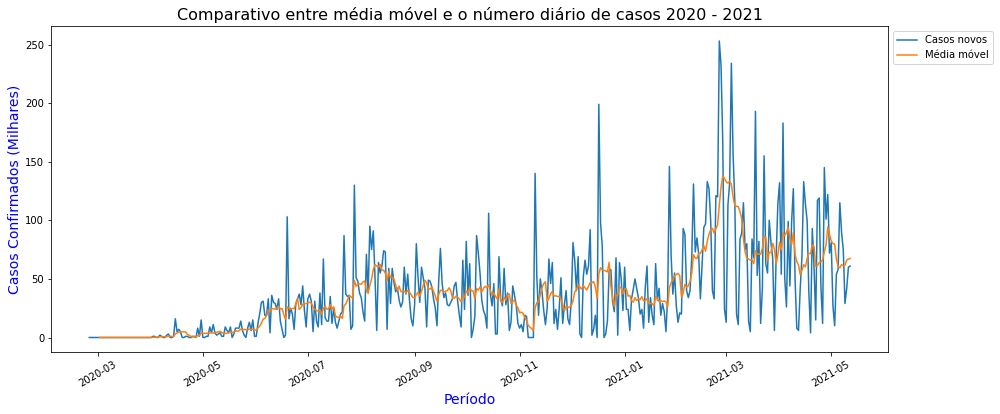

In [298]:
# Configurando o tamanho do gráfico
plt.figure(figsize=(15,6))

sns.lineplot(data=dados_araraquara, x='datahora', y='casos_novos')
sns.lineplot(data=dados_araraquara, x='datahora', y='media_movel_casos')

# Título do gráfico
plt.title('Comparativo entre média móvel e o número diário de casos 2020 - 2021', fontsize=16)

# Configurando as labels
plt.xlabel('Período', fontsize=14, color='b')
plt.ylabel('Casos Confirmados (Milhares)', fontsize=14, color='b')

# Configurando as legendas
plt.legend(labels=['Casos novos', 'Média móvel'], loc = 2, bbox_to_anchor = (1, 1))

# Configurando o eixo x
plt.xticks(rotation=30)

plt.show()

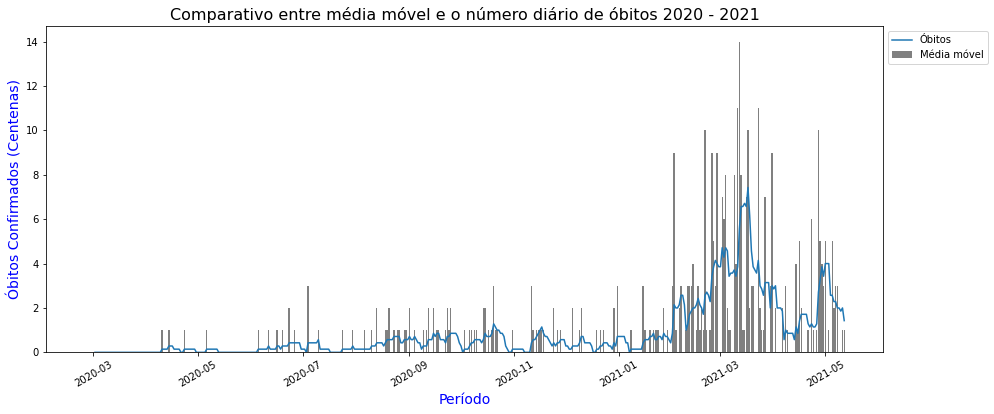

In [299]:
# Configurando o tamanho do gráfico
plt.figure(figsize=(15,6))

# criando o gráfico de óbitos diários
plt.bar(dados_araraquara['datahora'], dados_araraquara['obitos_novos'], color='grey')

# Criando o gráfico com a média móvel de óbitos
sns.lineplot(data=dados_araraquara, x='datahora', y='media_movel_obitos')

# Título do gráfico
plt.title('Comparativo entre média móvel e o número diário de óbitos 2020 - 2021', fontsize=16)

# Configurando as labels
plt.xlabel('Período', fontsize=14, color='b')
plt.ylabel('Óbitos Confirmados (Centenas)', fontsize=14, color='b')

# Configurando as legendas
plt.legend(labels=['Óbitos', 'Média móvel'], loc = 2, bbox_to_anchor = (1, 1))

# Configurando o eixo x
plt.xticks(rotation=30)

plt.show()

**Agora vamos verificar se há uma forte sazonalidade nos casos notificados**

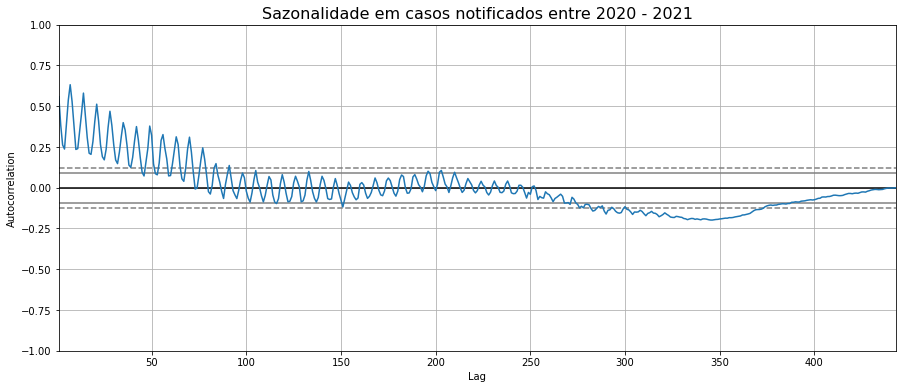

In [300]:
# Configurando o tamanho do gráfico
plt.figure(figsize=(15,6))
{}
autocorrelation_plot(dados_araraquara['casos_novos'])

# Título do gráfico
plt.title('Sazonalidade em casos notificados entre 2020 - 2021', fontsize=16)

plt.show()

O gráfico acima nos mostra que há uma forte sazonalidade nas notificações de casos de COVID-19 bem no início da série temporal. Porque podemos notar que a linha azul está fora da linha pontilhada e os números estão bem acima de zero, o que indica que há uma correlação temporal, uma sazonalidade nas notificações dos casos de COVID-19.

Porém, isso mudou à medida que o tempo foi passando e a pandemia foi evoluindo, hoje vemos que há um novo padrão nas notificações e com isso a sazonalidade também foi alterada.

# **3.0 - Treinando e testando os modelos**

## **3.1 - Primeiro modelo (com outliers)**

In [301]:
# Feriados em Araraquara

feriados_2020 = [
'2020-02-25',
'2020-02-26',
'2020-04-10',
'2020-02-25',
'2020-02-26',
'2020-04-10',
'2020-04-21',
'2020-05-01',
'2020-05-20',
'2020-05-21', 
'2020-05-22',
'2020-05-25',
'2020-06-11',
'2020-09-07',
'2020-10-12',
'2020-11-02',
'2020-11-15',
'2020-12-25'
]

feriados_2021 = [
'2021-01-01',
'2021-02-15',
'2021-02-16',
'2021-02-17',
'2021-03-26',
'2021-03-29',
'2021-03-30',
'2021-03-31',
'2021-04-01',
'2021-04-02',
'2021-04-21',
'2021-05-01',
'2021-06-03',
'2020-10-12',
'2020-11-02',
'2020-11-15',
'2020-12-25'
]

feriados_2020 = pd.DataFrame({
  'holiday': 'feriados_2020',
  'ds': pd.to_datetime(feriados_2020)
})

feriados_2021 = pd.DataFrame({
  'holiday': 'feriados_2021',
  'ds': pd.to_datetime(feriados_2021)
})

feriados = pd.concat((feriados_2020, feriados_2021))

In [302]:
# definindo uma data de corte
data_fim = '2021-04-30'

# definindo os dados de treino, antes da data de corte
treino = dados_araraquara.loc[dados_araraquara['datahora'] <= data_fim]

# Criando o dataframe de treino
df = pd.DataFrame()

df['ds'] = treino['datahora']
df['y'] = treino['casos_novos']


# definindo os dados de teste posterior a data de corte
teste = dados_araraquara.loc[dados_araraquara['datahora'] > data_fim]

# Criando o dataframe de treino
df_teste = pd.DataFrame()

df_teste['ds'] = teste['datahora']
df_teste['y'] = teste['casos_novos']

# contando a quantidade de dias à frente para checar a acurácia da previsão
dias_a_prever = len(df_teste['ds'].unique())
# checando a quantidade de dias
dias_a_prever

12

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


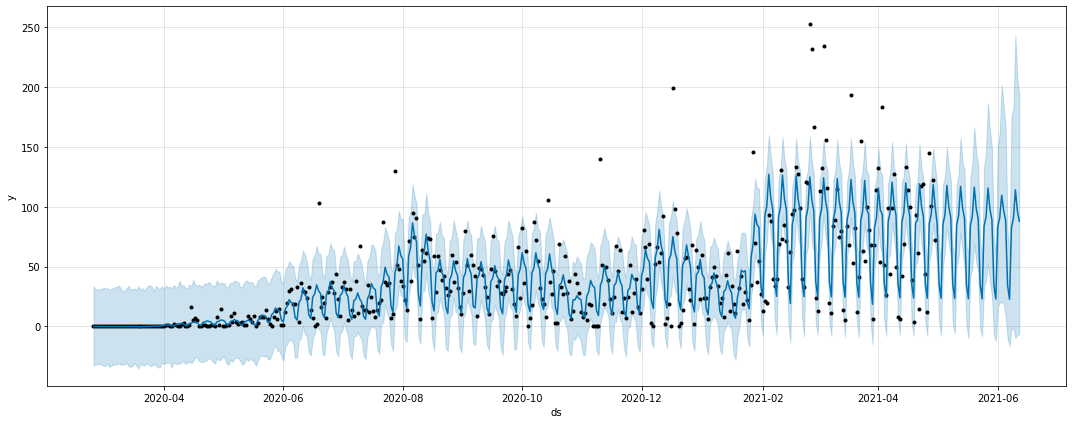

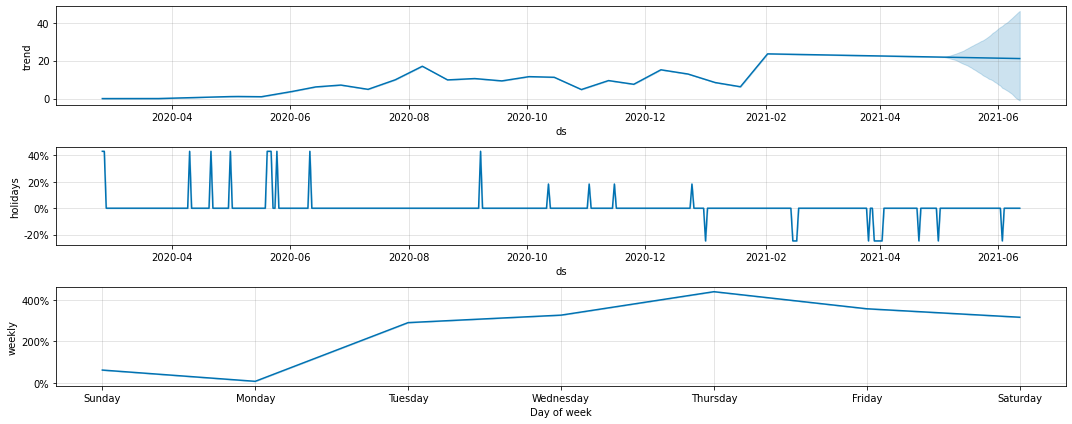

In [303]:
modelo = Prophet(n_changepoints=25, changepoint_prior_scale=30.0, holidays=feriados, seasonality_mode='multiplicative', weekly_seasonality=7)
modelo.fit(df)
dataframe_futuro = modelo.make_future_dataframe(periods=43)
previsao = modelo.predict(dataframe_futuro)
fig = modelo.plot(previsao, figsize=(15,6));
modelo.plot_components(previsao, figsize=(15,6));

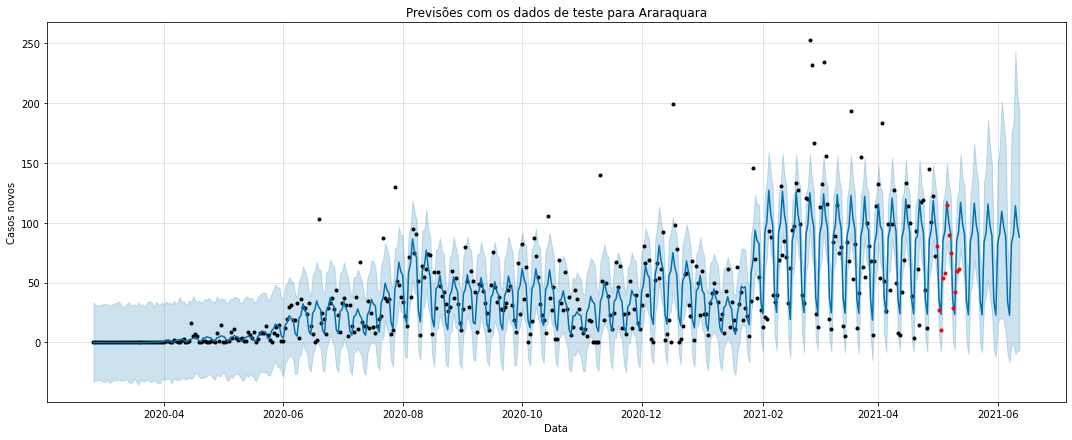

In [304]:
modelo.plot(previsao, xlabel='Data', ylabel='Casos novos', figsize=(15, 6));
plt.plot(df_teste['ds'], df_teste['y'], '.r') # '.r' para os pontos aparecerem em vermelho

# definindo o título
plt.title('Previsões com os dados de teste para Araraquara');
plt.show()

In [305]:
df_cv = cross_validation(modelo, initial='180 days', period='30 days', horizon='30 days')

INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-09-02 00:00:00 and 2021-03-31 00:00:00


In [306]:
janela = 6
cutoff = df_cv['cutoff'].unique()[janela]
df_cv_cut = df_cv[df_cv['cutoff'].values == cutoff]

Text(0.5, 0, 'ds')

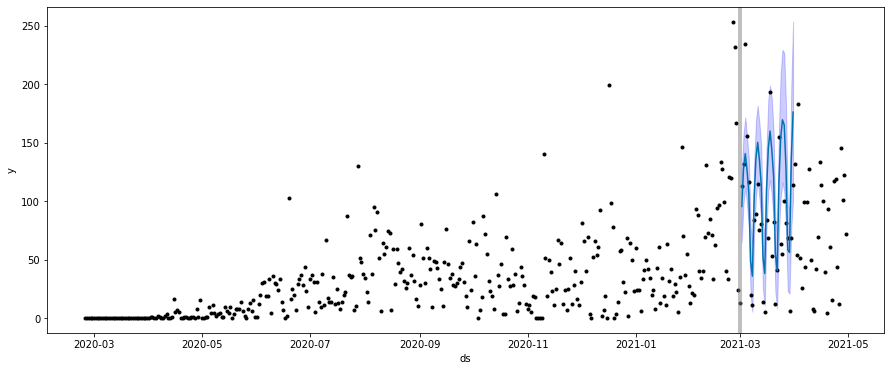

In [307]:
fig = plt.figure(figsize=(15,6))
ax= fig.add_subplot(111)
ax.plot(modelo.history['ds'].values, modelo.history['y'], 'k.')
ax.plot(df_cv_cut['ds'].values, df_cv_cut['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv_cut['ds'].values, df_cv_cut['yhat_lower'], df_cv_cut['yhat_upper'], color='blue', alpha= 0.2)
ax.axvline(x= pd.to_datetime(cutoff), c='gray', lw= 4, alpha= 0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')

In [308]:
df_performance = performance_metrics(df_cv)

INFO:fbprophet:Skipping MAPE because y close to 0


In [310]:
df_performance

,horizon,mse,rmse,mae,mdape,coverage
0,3 days,1180.759231,34.362177,26.250059,0.469959,0.458333
1,4 days,1233.379271,35.119500,27.672274,0.681169,0.333333
2,5 days,1074.658321,32.781982,26.120505,0.508684,0.458333
3,6 days,766.958868,27.694022,25.146916,0.637980,0.416667
4,7 days,1001.381129,31.644607,25.496268,0.481973,0.583333
5,8 days,1161.779927,34.084893,26.078408,0.493929,0.583333
6,9 days,1577.534506,39.718189,27.809020,0.482772,0.625000
7,10 days,1495.484698,38.671497,28.258993,0.486131,0.541667
8,11 days,1813.170337,42.581338,32.641352,0.548446,0.458333
9,12 days,1490.516978,38.607214,31.124000,0.596276,0.458333


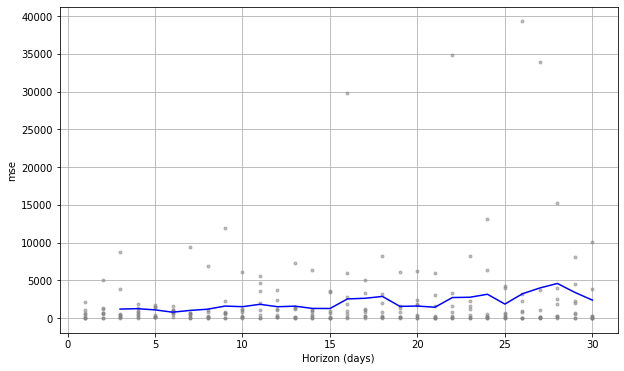

In [311]:
plot_cross_validation_metric(df_cv, metric='mse');

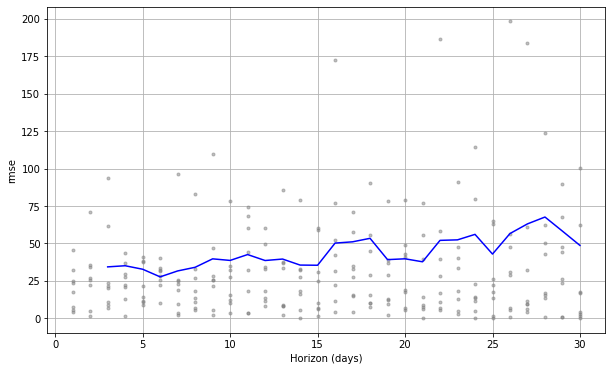

In [312]:
plot_cross_validation_metric(df_cv, metric='rmse');

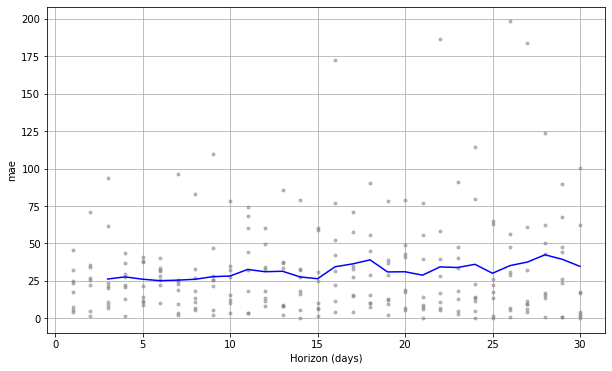

In [313]:
plot_cross_validation_metric(df_cv, metric='mae');

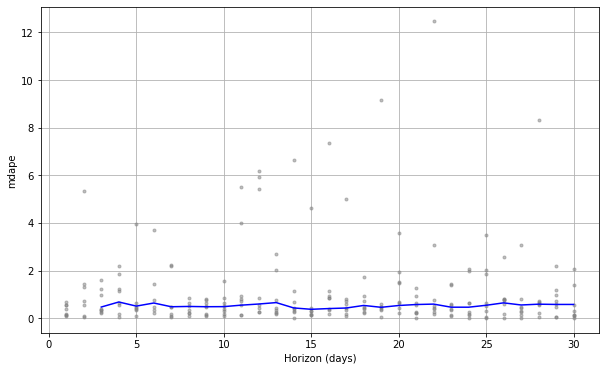

In [314]:
plot_cross_validation_metric(df_cv, metric='mdape');

In [315]:
# Métricas do sktLearn
print(f'Mae: ', mean_absolute_error(df['y'][:400], previsao['yhat'][:400]))
print(f'Mean Squared Error: ', mean_squared_error(df['y'][:400], previsao['yhat'][:400]))
print(f'Explained Variance Score: ', explained_variance_score(df_araraquara['y'][:400], previsao['yhat'][:400]))
print(f'R2: ', r2_score(df['y'][:400], previsao['yhat'][:400]))
print(f'Mean Tweedie Deviance (equivalente ao mean_squared_error)', mean_tweedie_deviance(df['y'][:400], previsao['yhat'][:400], power=0))

Mae:  14.620997970248268
Mean Squared Error:  580.8472775412295
Explained Variance Score:  0.6234429566719238
R2:  0.6230826352951571
Mean Tweedie Deviance (equivalente ao mean_squared_error) 580.8472775412295


## **3.2 - Segundo modelo (sem os outliers)**

In [316]:
# Primeiro para facilitar o trabalho, iremos remover o índice do df
novo_y = df.reset_index()
novo_y

,index,ds,y
0,36,2020-02-25,0
1,681,2020-02-26,0
2,1326,2020-02-27,0
3,1971,2020-02-28,0
4,2616,2020-02-29,0
...,...,...,...
426,274806,2021-04-26,12
427,275451,2021-04-27,145
428,276096,2021-04-28,101
429,276741,2021-04-29,122


In [317]:
# Retirando os outliers
sem_outliers = novo_y[(novo_y['y'] > previsao['yhat_lower'][:431]) 
& (novo_y['y'] < previsao['yhat_upper'][:431])]

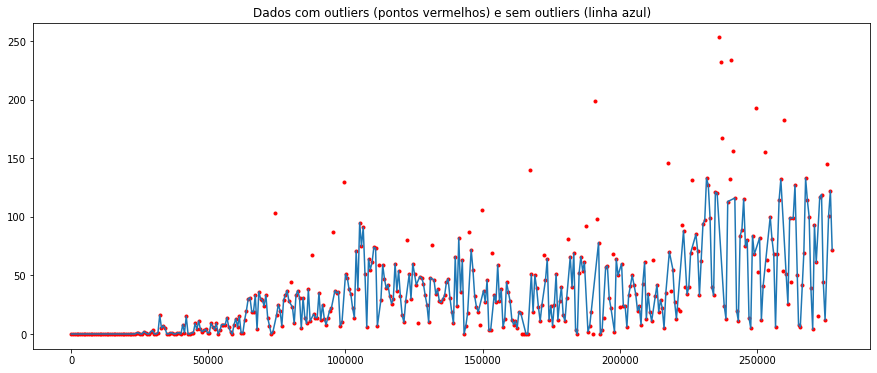

In [318]:
# PLotando os dados de treino com outliers
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['y'], 'r.')

plt.title('Dados com outliers (pontos vermelhos) e sem outliers (linha azul)')

# Plotando o gráfico de treino sem os outliers
plt.plot(sem_outliers['index'], sem_outliers['y'])

In [319]:
df_sem_outliers = sem_outliers[['ds', 'y']]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,feriados_2020,feriados_2020_lower,feriados_2020_upper,feriados_2021,feriados_2021_lower,feriados_2021_upper,holidays,holidays_lower,holidays_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
469,2021-06-08,21.181296,-1.191598,175.690008,2.459680,42.473471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.907138,2.907138,2.907138,2.907138,2.907138,2.907138,0.0,0.0,0.0,82.758234
470,2021-06-09,21.162274,-2.337508,182.531476,1.393633,43.466685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.268421,3.268421,3.268421,3.268421,3.268421,3.268421,0.0,0.0,0.0,90.329495
471,2021-06-10,21.143252,-9.545348,242.800974,0.338002,44.407635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.400299,4.400299,4.400299,4.400299,4.400299,4.400299,0.0,0.0,0.0,114.179889
472,2021-06-11,21.124230,-6.926277,207.936307,-0.390433,45.378104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.575595,3.575595,3.575595,3.575595,3.575595,3.575595,0.0,0.0,0.0,96.655918
473,2021-06-12,21.105208,-6.518696,193.146012,-1.037163,46.260367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.167138,3.167138,3.167138,3.167138,3.167138,3.167138,0.0,0.0,0.0,87.948326


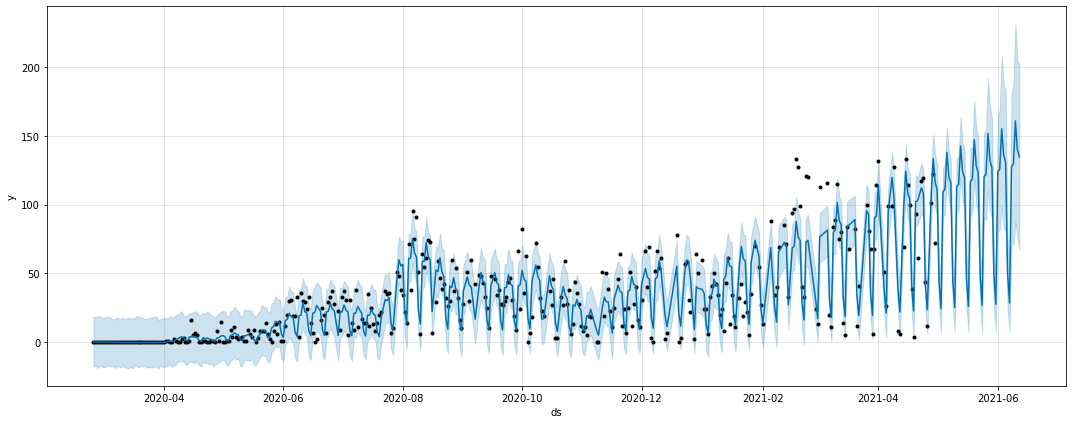

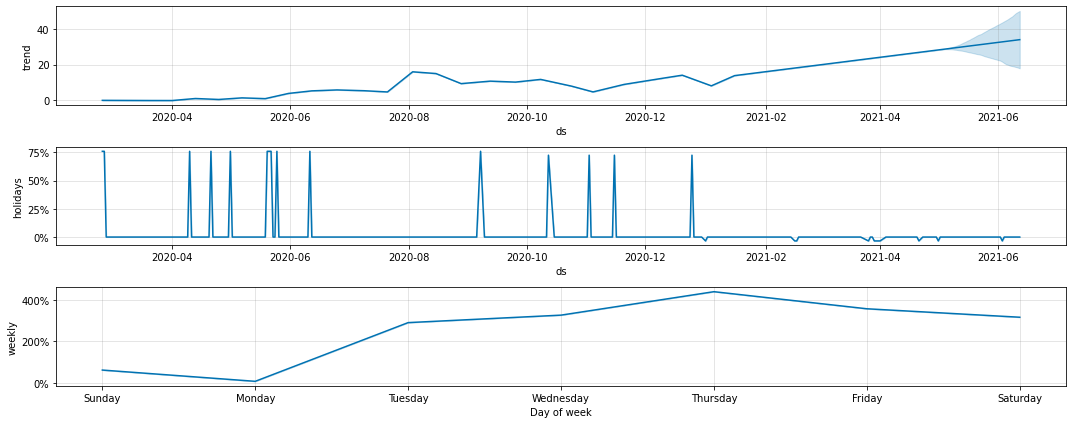

In [320]:
modelo_so = Prophet(n_changepoints=25, changepoint_prior_scale=30.0, holidays=feriados, seasonality_mode='multiplicative', weekly_seasonality=7)
modelo_so.fit(df_sem_outliers) # Passando o novo df sem os outliers para o nosso modelo
dataframe_futuro = modelo_so.make_future_dataframe(periods=43)
previsao_so = modelo_so.predict(dataframe_futuro)
fig = modelo_so.plot(previsao_so, figsize=(15,6));
modelo.plot_components(previsao_so, figsize=(15,6));

previsao.tail()

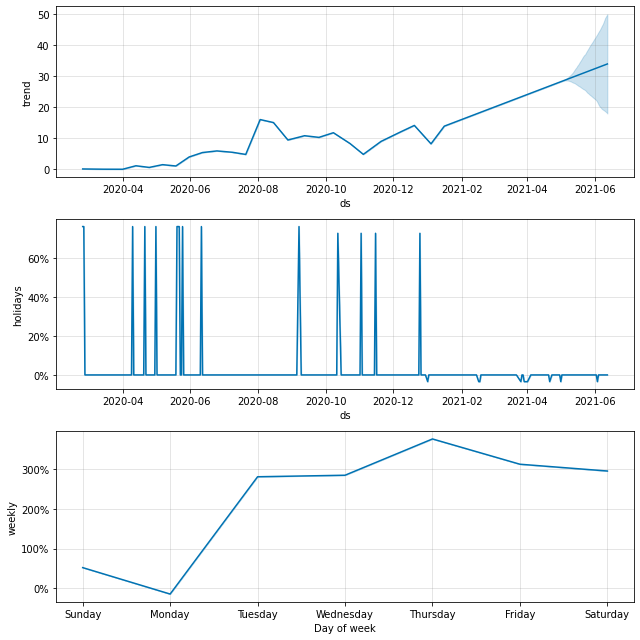

In [321]:
modelo_so.plot_components(previsao_so);

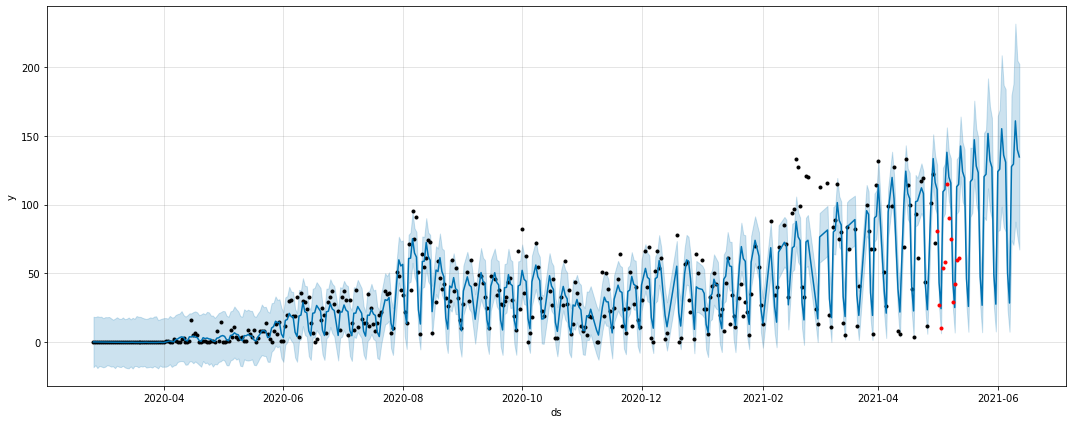

In [322]:
fig = modelo_so.plot(previsao_so, figsize=(15,6));
plt.plot(df_teste['ds'], df_teste['y'], '.r') # '.r' para os pontos aparecerem em vermelho

In [323]:
df_cv = cross_validation(modelo_so, initial='180 days', period='30 days', horizon='30 days')

INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-09-02 00:00:00 and 2021-03-31 00:00:00


In [324]:
janela = 7

cutoff = df_cv['cutoff'].unique()[janela]
df_cv_cut = df_cv[df_cv['cutoff'].values == cutoff]

Text(0.5, 0, 'ds')

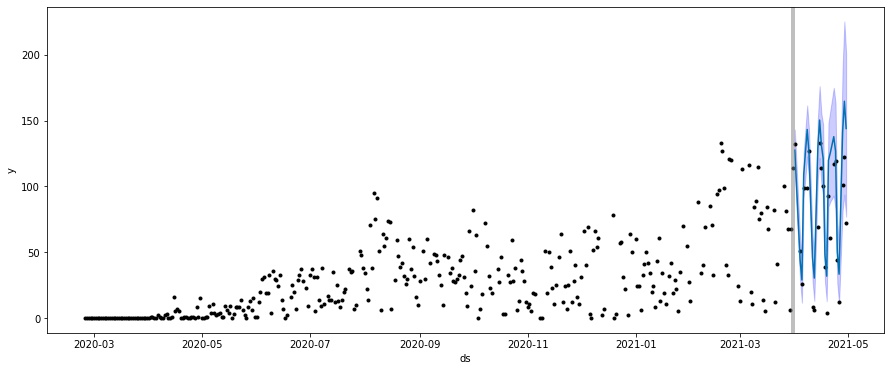

In [325]:
fig = plt.figure(figsize=(15,6))
ax= fig.add_subplot(111)
ax.plot(modelo_so.history['ds'].values, modelo_so.history['y'], 'k.')
ax.plot(df_cv_cut['ds'].values, df_cv_cut['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv_cut['ds'].values, df_cv_cut['yhat_lower'], df_cv_cut['yhat_upper'], color='blue', alpha= 0.2)
ax.axvline(x= pd.to_datetime(cutoff), c='gray', lw= 4, alpha= 0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')

In [326]:
df_performance = performance_metrics(df_cv)

INFO:fbprophet:Skipping MAPE because y close to 0


In [327]:
df_performance

,horizon,mse,rmse,mae,mdape,coverage
0,4 days,432.468158,20.795869,16.993078,0.545117,0.511278
1,5 days,388.367070,19.707031,16.249982,0.545117,0.561404
2,6 days,431.120180,20.763434,17.067947,0.527398,0.526316
3,7 days,431.580173,20.774508,17.635569,0.527398,0.515789
4,8 days,481.769757,21.949254,17.905912,0.447190,0.508772
5,9 days,411.605765,20.288070,16.038464,0.414429,0.561404
6,10 days,439.972138,20.975513,16.727737,0.447190,0.552632
7,11 days,414.295858,20.354259,16.448838,0.456959,0.578947
8,12 days,471.665271,21.717856,18.123958,0.513007,0.556391
9,13 days,471.246664,21.708217,17.845908,0.420558,0.609023


In [329]:
# Métricas do sktLearn
print(f'Mae: ', mean_absolute_error(df_sem_outliers['y'][:376], previsao_so['yhat'][:376]))
print(f'Mean Squared Error: ', mean_squared_error(df_sem_outliers['y'][:376], previsao_so['yhat'][:376]))
print(f'Explained Variance Score: ', explained_variance_score(df_sem_outliers['y'][:376], previsao_so['yhat'][:376]))
print(f'R2: ', r2_score(df_sem_outliers['y'][:379], previsao_so['yhat'][:376]))
print(f'Mean Tweedie Deviance (equivalente ao mean_squared_error)', mean_tweedie_deviance(df_sem_outliers['y'][:376], previsao_so['yhat'][:376], power=0))

Mae:  9.761250342787788
Mean Squared Error:  194.00807796528215
Explained Variance Score:  0.8051751404014854
R2:  0.8050235700840094
Mean Tweedie Deviance (equivalente ao mean_squared_error) 194.00807796528215


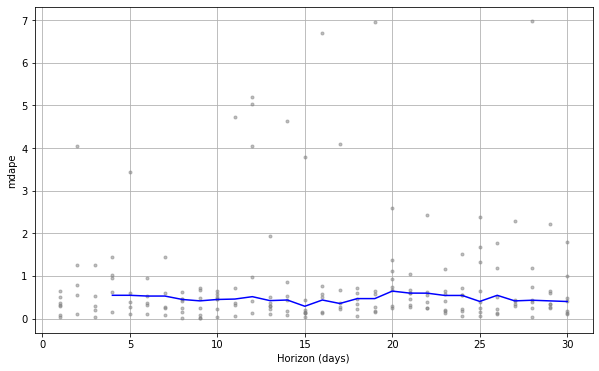

In [330]:
plot_cross_validation_metric(df_cv, metric='mdape');

# **4.0 - Conclusão**

Não foi adicionado na modelagem as medidas de distanciamento social mais restritivas, os chamados lockdown. Os dados vão até maio de 2021, fazendo com que tenhamos um pouco mais de um ano de coleta de dados, o que não é muito para criar uma análise preditiva mais robusta. Mesmo assim, foi possível criar modelos de previsão que apesar de algumas limitações, estarem bem ajustados e com métricas dentro de padrões aceitáveis.

Estimativas como esta, realizadas neste projeto, tem como objetivo ajudar na tomada de decisões de gerentes em todas as áreas de atuação econômica e até mesmo da gestão pública. No nosso caso específico, no combate à COVID-19.

Usando modelos preditivos de machine learning poderíamos prever aumentos de casos e prever quando ocorreriam as próximas ondas de COVID-19, evitando que falte insumos importantes no combate à doença como oxigênio, remédios para intubação, entre outros, e também quando aumentar as restrições de convívio social. Sendo possível aplicar em outras áreas da gestão pública, evitando assim, desperdícios e má empregabilidade de recursos públicos.